# snATAC-seq - doublet scoring with Scrublet

Blanca Pijuan-Sala

17 April 2019

In [1]:
#Scrublet depends on numpy 1.15 (it doesn't work with 1.16) - pip install numpy==1.15
import numpy as np
from matplotlib import rcParams
import matplotlib.pyplot as pl
import scanpy.api as sc
import pandas as pd
import matplotlib.pyplot as plt

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=100, color_map='viridis')  # low dpi (dots per inch) yields small inline figures
sc.logging.print_versions()
#Set working directory
wd = '/path/to/directory/sample_pooled_preprocess_revision1/'
direc = wd
sc.settings.figdir = './plots/'


/home/USSR/bp382/bin/python/anaconda3/lib/python3.6/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning


scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.7 numpy==1.15.0 scipy==1.3.0 pandas==0.24.0 scikit-learn==0.20.2 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


## Read files

In [7]:
##====== Read counts ======##

filename_data = direc + '06_matrix/embryo_revision1_allPeaks_passedQC.mat.bin.mtx'
filename_gene_names = direc + '06_matrix/embryo_revision1_allPeaks_passedQC_peakNames.txt'
filename_barcodes = direc + '06_matrix/embryo_revision1_allPeaks_passedQC_barcodeNames.xgi'
#filename_clustersAll = wd + 'data/cellTypes_20180215.txt'
#adata_all_cells = epi.tl.read_ATAC(filename_data, filename_barcodes, filename_gene_names,path_file='')

print('reading counts')
adata_all_cells = sc.read(filename_data, cache=True).transpose()
adata_all_cells.X = adata_all_cells.X.astype(np.int64)
print('reading genes')
adata_all_cells.var_names = np.genfromtxt(filename_gene_names, dtype='str')
print('reading cells')
adata_all_cells.obs_names = np.genfromtxt(filename_barcodes, dtype='str')

reading counts
Only considering the two last: ['.bin', '.mtx'].
Only considering the two last: ['.bin', '.mtx'].
... reading from cache file cache/home-USSR-codex-pipeline-Data-Rebecca-Blanca-sample_pooled_preprocess_revision1-06_matrix-embryo_revision1_allPeaks_passedQC.mat.bin.h5ad
reading genes
reading cells


In [8]:
adata_all_cells.shape

(23838, 303418)

# Filtering peaks

In [9]:
#Take out those coordinates that do not fall within chr[0-9]
notWantedFilename =direc + '06_matrix/chr_not_wanted_BED.txt'
notWanted = np.genfromtxt(notWantedFilename, dtype='str')


In [10]:
adatabin=adata_all_cells[:,[i not in notWanted for i in adata_all_cells.var_names]]

In [11]:
del adata_all_cells

In [12]:
adatabin.shape

(23838, 303332)

In [15]:
#sc.write(results_file,adata)

Remove regions with 0 counts

In [13]:
numPeaks = np.sum(adatabin.X,axis=0).transpose()

passQC = numPeaks > 0

adatatop = adatabin[:,list(np.array(passQC)[:,0])]


In [14]:
adatatop.shape

(23838, 301099)

# cisTopic 50-100 

In [56]:
adata = adatatop

In [112]:
from scipy.io import mmread
cistopic = mmread(direc + '07_doublet_removal/data/cisTopic_matrix_50_100.mtx')


In [113]:
cistopic = cistopic.todense()
cistopic= cistopic.transpose()
cistopic.shape

(23838, 100)

In [114]:
adata.obsm['X_pca'] = cistopic

In [ ]:
sc.write("./write/20190416_snATACseq_embryo_revision01_doublets_cisTopic_50_100.h5ad",adata)

# Doublet scoring with binary data

https://github.com/AllonKleinLab/scrublet/blob/master/old_versions/v0.1/examples/10X_PBMC-8k_example.ipynb

In [10]:
adata = sc.read("./write/20190416_snATACseq_embryo_revision01_doublets_cisTopic_50_100.h5ad")


In [3]:
adata.shape

(23838, 301099)

In [4]:
%matplotlib inline
import scrublet as scr
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import os
import time

In [5]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rc('font', size=14)
plt.rcParams['pdf.fonttype'] = 42

In [6]:
scrub = scr.Scrublet(adata.X, expected_doublet_rate=0.1)
#If you want to simulate more doublets, increase the doublet rate

## Plot the counts in cells

Text(0, 0.5, 'Number of cells')

/home/USSR/bp382/bin/python/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


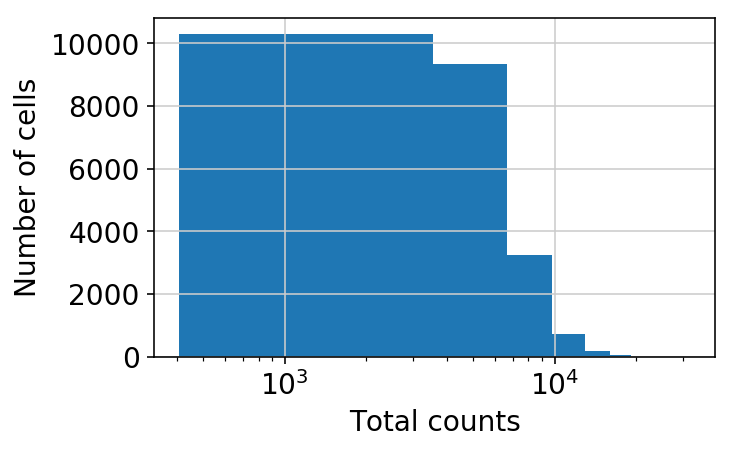

In [7]:
E = adata.X
total_counts = adata.X.sum(1).A.squeeze()

fig, ax = plt.subplots(figsize = (5, 3))
ax.hist(total_counts)
ax.set_xscale('log')
ax.set_xlabel('Total counts')
ax.set_ylabel('Number of cells')

In [8]:
doublet_scores, predicted_doublets = scrub.scrub_doublets(min_counts=0.001, 
                                                          min_cells=0.001,
                                                          min_gene_variability_pctl=20,
                                                          n_prin_comps=100)

Preprocessing...


/home/USSR/bp382/bin/python/anaconda3/lib/python3.6/site-packages/scrublet/helper_functions.py:251: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...


/home/USSR/bp382/bin/python/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/USSR/bp382/bin/python/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  return f(*args, **kwds)


Automatically set threshold at doublet score = 0.35
Detected doublet rate = 4.9%
Estimated detectable doublet fraction = 38.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 12.8%
Elapsed time: 2027.8 seconds


## Set the doublet threshold to 0.4

In [29]:
scrub.call_doublets(threshold=0.40)

Detected doublet rate = 3.2%
Estimated detectable doublet fraction = 29.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 11.1%


array([False, False, False, ..., False, False, False])

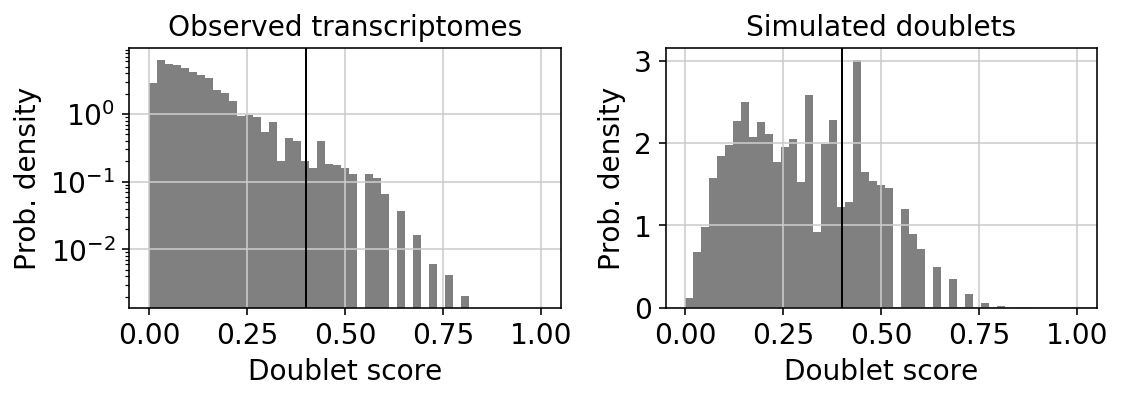

In [30]:
scrub.plot_histogram();


In [11]:
adata.obs['doublet_scores'] = doublet_scores


In [15]:
meta = pd.DataFrame(data=adata.obs)
meta.to_csv(direc + '07_doublet_removal/data/snATACseq_embryo_revision01_doublets_cisTopic_50_100_metadata.csv', sep=',')


In [ ]:
sc.write("./write/20190416_snATACseq_embryo_revision01_doublets_cisTopic_50_100.h5ad",adata)